## moDel Agnostic Language for Exploration and eXplanation 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
# pd.__version__ == 1.1.2
data = pd.read_csv("./happiness.csv", index_col=0)
X, y = data.drop('score', axis=1), data.score
n, p = X.shape
data.head()

,score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption
Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025
Albania,4.719,0.947,0.848,0.874,0.383,0.178,0.027
Algeria,5.211,1.002,1.160,0.785,0.086,0.073,0.114
Argentina,6.086,1.092,1.432,0.881,0.471,0.066,0.050
Armenia,4.559,0.850,1.055,0.815,0.283,0.095,0.064


In [3]:
import tensorflow as tf
# tf.__version__ == 2.3.0
tf.random.set_seed(11)

normalizer  = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[p,])
normalizer.adapt(X.to_numpy())

model = tf.keras.Sequential([
    normalizer,
    tf.keras.Input(shape=(p,)),
    tf.keras.layers.Dense(p*2, activation='relu'),
    tf.keras.layers.Dense(p*3, activation='relu'),
    tf.keras.layers.Dense(p*2, activation='relu'),
    tf.keras.layers.Dense(p, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.mae
)

model.fit(X, y, batch_size=int(n/10), epochs=2000, verbose=False)

2024-03-03 19:17:30.764144: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [5]:
import dalex as dx 
dx.__version__


'1.7.0'

In [6]:
explainer = dx.Explainer(model, X, y, label='happiness')

Preparation of a new explainer is initiated

  -> data              : 156 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 156 values
  -> model_class       : keras.engine.sequential.Sequential (default)
  -> label             : happiness
  -> predict function  : <function yhat_tf_regression at 0x2e7422c20> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 5.34, max = 9.16
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -2.9, mean = 0.0673, max = 3.52
  -> model_info        : package keras

A new explainer has been created!


In [7]:
explainer.model_performance()

,mse,rmse,r2,mae,mad
happiness,1.820443,1.349238,-0.47872,1.038673,0.803827


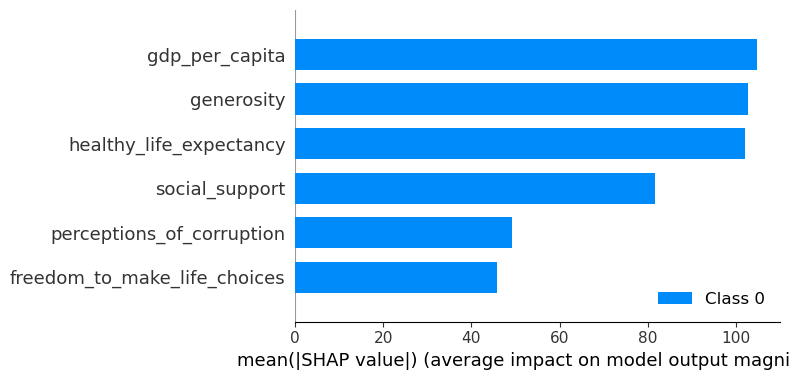

In [9]:

explainer.model_parts().plot()
explainer.model_parts(type='shap_wrapper').plot()

In [12]:
explainer.model_profile().plot(variables=['social_support', 'healthy_life_expectancy',
                                          'gdp_per_capita', 'freedom_to_make_life_choices'])


Calculating ceteris paribus: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


In [13]:
explainer.model_diagnostics().plot(variable='social_support', marker_size=5, line_width=3)


In [14]:
explainer.predict_parts(X.loc['Poland'], type='shap').plot()

In [15]:
pp_list = []
for country in ['Afghanistan', 'Belgium', 'China', 'Denmark', 'Ethiopia','India','Pakistan','Netherlands']:
    pp = explainer.predict_parts(X.loc[country], type='break_down')
    pp.result.label = country
    pp_list += [pp]
pp_list[0].plot(pp_list[1::], min_max=[2.5, 8.5])